In [1]:
#Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import keras
from keras_preprocessing.image import load_img
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input

from PIL import Image
from tqdm import tqdm

In [2]:
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display

import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [3]:
# reading all the images into a seperate variable

images='./kaggle/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images in the dataset: {}".format(len(all_imgs)))

The total images in the dataset: 8091


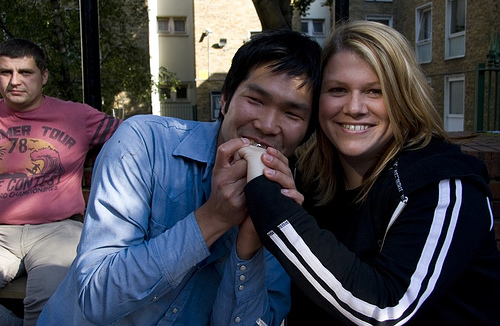

In [4]:
# view a random image

import random
Image.open(all_imgs[random.randrange(30, 80, 3)])

In [5]:
# reading all the text file into a separate variable

text_file = './kaggle/captions.txt'

def load_doc(filename):
    open_file = open(text_file,'r', encoding='utf-8')
    text = open_file.read()
    open_file.close()
    return text

doc = load_doc(text_file)   #reading the content of the captions file into doc
print(doc[:400])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .


In [6]:
# Create a dataframe which summarizes the image, its path & captions related to it
# Each image has 5 captions associated with it

all_img_id = [] #store all the image id
all_img_vector = [] #store all the image path
annotations =[] #store all the captions 

with open('./kaggle/captions.txt', 'r') as fo:
    for line in fo :
        split_arr = line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.
        all_img_vector.append('./kaggle/Images/'+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id,all_img_vector,annotations)),columns =['Id','Path','Captions']) 
    
df

Id                                       Path  \
0      1000268201_693b08cb0e.jpg  ./kaggle/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  ./kaggle/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  ./kaggle/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  ./kaggle/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  ./kaggle/Images/1000268201_693b08cb0e.jpg   
...                          ...                                        ...   
40450   997722733_0cb5439472.jpg   ./kaggle/Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   ./kaggle/Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   ./kaggle/Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   ./kaggle/Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   ./kaggle/Images/997722733_0cb5439472.jpg   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                   A girl going into a wooden building   
2        A little girl climbing into a wooden playhouse   
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451            A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock fac...  
40453                     A rock climber in a red shirt   
40454  A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [7]:
def caption_with_img_plot(image_id, frame) :
    captions = ("\n" *2).join(frame[frame['Id'] == image_id].Captions.to_list())
    fig, ax = plt.subplots()
    idx = df.Id.to_list().index(image_id)
    im = Image.open(df.Path.iloc[idx])
    w, h = im.size[0], im.size[-1]
    ax.imshow(im)
    ax.text(w+50, h, captions, fontsize = 18)

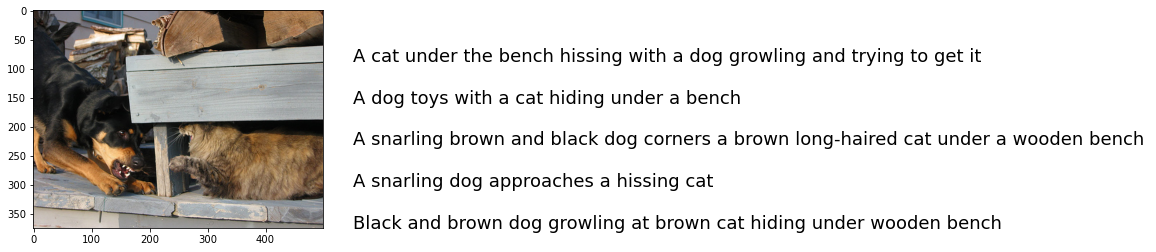

In [8]:
caption_with_img_plot(df.Id.iloc[1050], df)

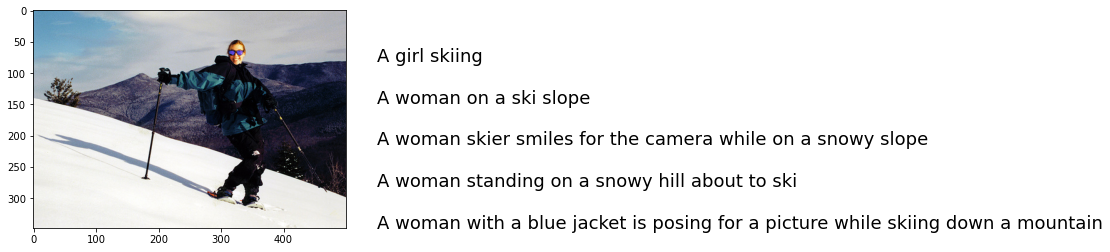

In [9]:
caption_with_img_plot(df.Id.iloc[5050], df)

In [10]:
#check total captions and images present in dataset

print("Total number of captions: "+ str(len(annotations)))
print("Total number of images: " + str(len(all_imgs)))

Total number of captions: 40455
Total number of images: 8091


In [11]:
# generating the vocabulary 

vocabulary = [word.lower() for line in annotations for word in line.split()]

#Create a HashTable to map each word with its frequency

val_count = Counter(vocabulary) 
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

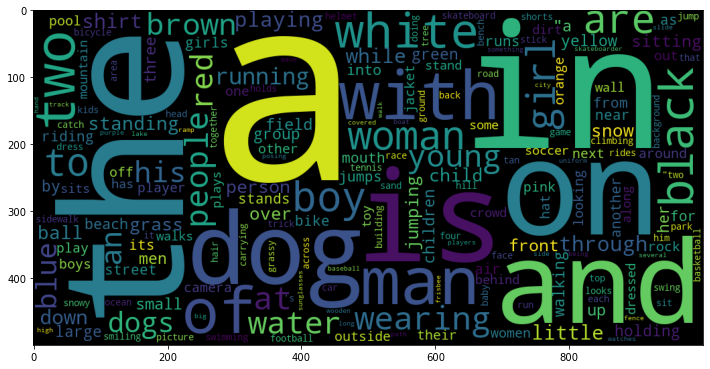

In [12]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

In [13]:
import string
rem_punct = str.maketrans('', '', string.punctuation)

for r in range(len(annotations)) :
    line = annotations[r].split()
    line = [word.lower() for word in line]
    
    line = [word.translate(rem_punct) for word in line] # remove punctuation from each caption
    line = [word for word in line if len(word) > 1]    
    line = [word for word in line if word.isalpha()]    # remove alhpa-numeric values

    annotations[r] = ' '.join(line)

In [14]:
#add the <start> & <end> token to all captions
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

In [15]:
#list contatining captions for an image
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [16]:
top_word_cnt = 5000

tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ', lower = True, char_level = False, 
                      oov_token = 'UNK') #defining out-of-vocabulary word as 'UNK'

tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations) #transform each text into a sequence of integers

In [17]:
# we add PAD token for zero

tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [18]:
# View index words mapping

tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [19]:
# Inputs should be in similar in shape and size
# Padding each vector to the max_length of the captions

train_seqs_len = [len(seq) for seq in train_seqs] # store the length of all lists
longest_word_length = max(train_seqs_len)         # store elements from list with maximum length
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs , padding= 'post', maxlen = longest_word_length, dtype='int32', value= 0)

cap_vector[:5]

array([[   2,   43,    4,   88,  169,    7,  115,   52,  390,   12,  382,
           4,   28,    1,  687,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   19,  309,   63,  193,  119,    3,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   37,   19,  115,   63,  193, 2354,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   37,   19,  115,    5,  382,   20,   62, 2354,    3,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   2,   37,   19,    4,   88,  169,  309,   63,  193, 2889,    3,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

In [20]:
## function to return each image along with its path
image_shape = (299, 299)

def load_images(image_path) :
    img = tf.io.read_file(image_path, name = None)
    img = tf.image.decode_jpeg(img, channels = 0)
    img = tf.image.resize(img, image_shape)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img, image_path

In [21]:
training_list = sorted(set(all_img_vector))

dataset = tf.data.Dataset.from_tensor_slices(training_list)
dataset = dataset.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)

dataset = dataset.batch(64, drop_remainder=False)

In [22]:
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [23]:
path_train, path_test, caption_train, caption_test = train_test_split(all_img_vector, cap_vector, 
                                                                      test_size = 0.2, random_state = 0)

In [24]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [25]:
# instead of shuffling entire sequence, maintains separate buffer within which to shuffles elements. 

# We will set reshuffle_each_iteration to True in order to ensure different order per epoch

# We will use the prefetch function to prepare later elements as the current ones are being processed

In [26]:
# create a builder function to create dataset which takes in the image path & captions as input
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier

BUFFER_SIZE = 1000
BATCH_SIZE  = 64

def map(image_name, caption):    
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

# function to create train test dataset
def generate_dataset(img_path, capt):
    data = tf.data.Dataset.from_tensor_slices((img_path, capt)) 
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True)
            .batch(BATCH_SIZE, drop_remainder = False)
            .prefetch(tf.data.experimental.AUTOTUNE ))
    
    return data

In [27]:
# create train and test dataset

train_dataset = generate_dataset(path_train,caption_train)
test_dataset = generate_dataset(path_test,caption_test)

In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

input_layer = image_model.input #to get the input of the image_model
hidden_layer = image_model.layers[-1].output  #to get the output of the image_model

image_features_extract_model = tf.compat.v1.keras.Model(input_layer, hidden_layer) #build the final model using both input & output layer

In [29]:
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [30]:
# extract features from each image in the dataset
img_features = {}

for image, image_path in tqdm(dataset) :
    batch_features = image_features_extract_model(image) # feed images from dataset to above model
    batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3])) # squeeze out the features in a batch
    
    for batch_feat, path in zip(batch_features_flattened, image_path) :
        feature_path = path.numpy().decode('utf-8')
        img_features[feature_path] = batch_feat.numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 127/127 [02:03<00:00,  1.03it/s]


In [31]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.72686452e-02, 0.00000000e+00, ...,
          2.32006520e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07906133e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.93917036e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85910851e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.42182317e-02, 0.00000000e+00, 5.05754113e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.22906876e-01, 1.32462289e-02, ...,
          2.33845383e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [56]:
# Setting  parameters

embedding_dim = 256 
units = 512
vocab_size = 5000

max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

In [33]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [34]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0.0)
        return features

In [35]:
encoder = Encoder(embedding_dim)

In [138]:
from keras.utils.vis_utils import plot_model
plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [37]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)

        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = hidden[:, tf.newaxis]

        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features 

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights

In [38]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [39]:
decoder = Decoder(embedding_dim, units, vocab_size+1)

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [41]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ = loss_ * mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [42]:
# Why Masking ?
# Padding can result in a risk of adding penalty to the model.

# Once the padding is done, we need to apply 'masking'.

# Without masking, the model will consider the padded input at that timestep, which will contribute to an increased loss.

# Through masking we need to inform the model to ignore whenever a padded input is passed at a timestep, hinting that this part of the input is padded.

# We apply masking to rectify the same and this will truncate down all the added penalties back to zero :

In [43]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,decoder=decoder,optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [44]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [45]:
@tf.function
def train_test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        encoder_op = encoder(img_tensor)
        #apply teacher forcing by passing target word as next input to the decoder
        for r in range(1, target.shape[1]) :
            predictions, hidden, _ = decoder(dec_input, encoder_op, hidden) #pass encoder_op to decoder
            loss = loss + loss_function(target[:, r], predictions) 
            dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) # calculating gradient wrt each trainable var

    #we will now compute the gradients and apply it to the optimizer while backpropagating
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [46]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
        batch_loss, t_loss = train_test_step(img_tensor, target)
        total_loss = total_loss + t_loss
        avg_test_loss = total_loss/ len(path_test)

    return avg_test_loss

In [47]:
train_loss_plot = []
test_loss_plot = []
EPOCHS = 20

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_test_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / len(path_train)
        
    train_loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('Epoch: {}, train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch: 1, train loss is 0.023, & test loss is 0.019
Test loss has been reduced from 100.000 to 0.019


  5%|████                                                                            | 1/20 [06:44<2:08:02, 404.34s/it]

Epoch: 2, train loss is 0.017, & test loss is 0.016
Test loss has been reduced from 0.019 to 0.016


 10%|████████                                                                        | 2/20 [11:05<1:35:57, 319.84s/it]

Epoch: 3, train loss is 0.016, & test loss is 0.015
Test loss has been reduced from 0.016 to 0.015


 15%|████████████                                                                    | 3/20 [14:56<1:19:13, 279.62s/it]

Epoch: 4, train loss is 0.015, & test loss is 0.014
Test loss has been reduced from 0.015 to 0.014


 20%|████████████████                                                                | 4/20 [18:25<1:07:08, 251.77s/it]

Epoch: 5, train loss is 0.014, & test loss is 0.013
Test loss has been reduced from 0.014 to 0.013


 25%|████████████████████                                                            | 5/20 [22:16<1:01:02, 244.15s/it]

Epoch: 6, train loss is 0.013, & test loss is 0.012
Test loss has been reduced from 0.013 to 0.012


 30%|████████████████████████▌                                                         | 6/20 [25:30<52:57, 226.93s/it]

Epoch: 7, train loss is 0.012, & test loss is 0.012
Test loss has been reduced from 0.012 to 0.012


 35%|████████████████████████████▋                                                     | 7/20 [28:57<47:49, 220.69s/it]

Epoch: 8, train loss is 0.011, & test loss is 0.011
Test loss has been reduced from 0.012 to 0.011


 40%|████████████████████████████████▊                                                 | 8/20 [32:36<44:02, 220.18s/it]

Epoch: 9, train loss is 0.011, & test loss is 0.010
Test loss has been reduced from 0.011 to 0.010


 45%|████████████████████████████████████▉                                             | 9/20 [36:06<39:45, 216.85s/it]

Epoch: 10, train loss is 0.010, & test loss is 0.010
Test loss has been reduced from 0.010 to 0.010


 50%|████████████████████████████████████████▌                                        | 10/20 [39:10<34:28, 206.85s/it]

Epoch: 11, train loss is 0.010, & test loss is 0.009
Test loss has been reduced from 0.010 to 0.009


 55%|████████████████████████████████████████████▌                                    | 11/20 [42:29<30:38, 204.32s/it]

Epoch: 12, train loss is 0.009, & test loss is 0.009
Test loss has been reduced from 0.009 to 0.009


 60%|████████████████████████████████████████████████▌                                | 12/20 [46:12<28:00, 210.03s/it]

Epoch: 13, train loss is 0.009, & test loss is 0.008
Test loss has been reduced from 0.009 to 0.008


 65%|████████████████████████████████████████████████████▋                            | 13/20 [49:41<24:28, 209.81s/it]

Epoch: 14, train loss is 0.008, & test loss is 0.008
Test loss has been reduced from 0.008 to 0.008


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [53:32<21:36, 216.01s/it]

Epoch: 15, train loss is 0.008, & test loss is 0.008
Test loss has been reduced from 0.008 to 0.008


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [57:04<17:53, 214.80s/it]

Epoch: 16, train loss is 0.007, & test loss is 0.007
Test loss has been reduced from 0.008 to 0.007


 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:00:29<14:07, 211.95s/it]

Epoch: 17, train loss is 0.007, & test loss is 0.007
Test loss has been reduced from 0.007 to 0.007


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:04:15<10:48, 216.23s/it]

Epoch: 18, train loss is 0.007, & test loss is 0.007
Test loss has been reduced from 0.007 to 0.007


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:08:05<07:20, 220.43s/it]

Epoch: 19, train loss is 0.006, & test loss is 0.006
Test loss has been reduced from 0.007 to 0.006


 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:11:24<03:33, 213.90s/it]

Epoch: 20, train loss is 0.006, & test loss is 0.006
Test loss has been reduced from 0.006 to 0.006


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:15:15<00:00, 225.77s/it]


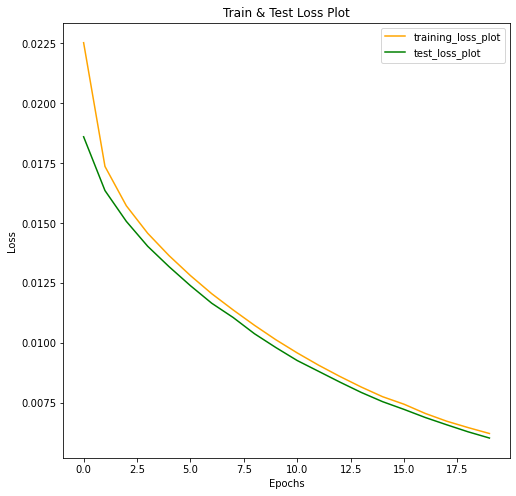

In [48]:
from matplotlib.pyplot import figure

figure(figsize=(8, 8))
plt.plot(train_loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train & Test Loss Plot')

plt.legend()
plt.show()

In [49]:
# Model Evaluation

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) # Process the input image before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot, predictions

In [50]:
def plot_attention_map (caption, weights, image) :
    fig = plt.figure(figsize = (10, 10))
    temp_img = np.array(Image.open(image))

    cap_len = len(caption)
    for cap in range(cap_len) :
        weights_img = np.reshape(weights[cap], (8,8))
        wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))

        ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
        ax.set_title(caption[cap], fontsize = 14, color = 'red')
        img = ax.imshow(temp_img)
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
        ax.axis('off')
        
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [51]:
from nltk.translate.bleu_score import sentence_bleu

In [52]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [53]:
image_test = path_test.copy()

In [54]:
def pred_caption(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :
    cap_test_data = caption_test.copy()
    rid = np.random.randint(0, random)
    test_image = image_test[rid]

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)

    real_caption = filt_text(real_caption)      
    pred_caption = ' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights = weights) #set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)

    return test_image

In [ ]:
# Our evaluation metric : BLUE SCORE (Bilingual Evaluation Understudy)

BELU score: 100.0
Real Caption: two girls hang upside down at park
Prediction Caption: two girls hang upside down at park


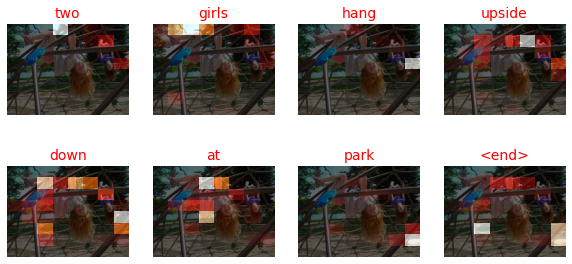

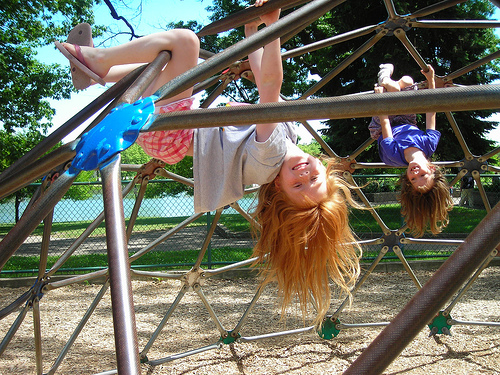

In [57]:
test_image = pred_caption(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BELU score: 90.0051435919627
Real Caption: large bird flaps its wings above the water
Prediction Caption: white bird flaps its wings above the water


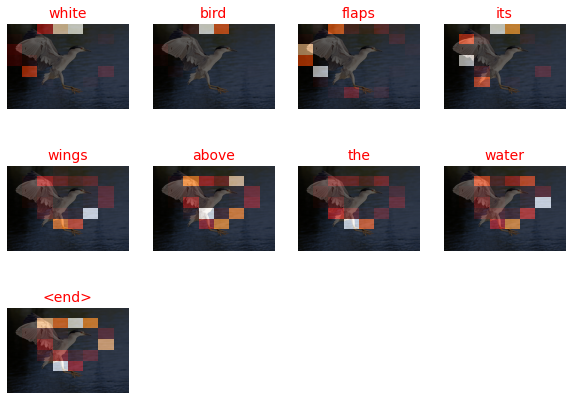

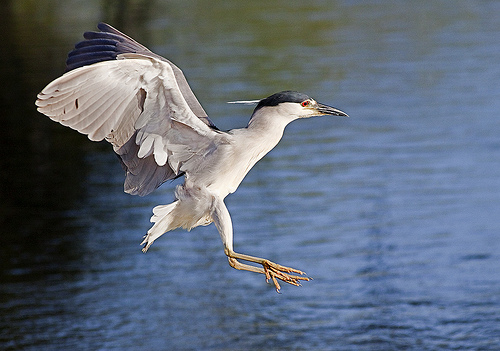

In [59]:
test_image = pred_caption(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BELU score: 90.17292432774606
Real Caption: little boy dressed as pirate holding up skull and crossbones flag
Prediction Caption: little boy dressed like pirate holding up skull and crossbones flag


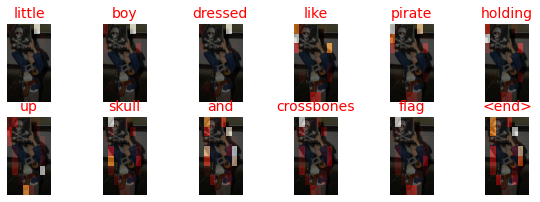

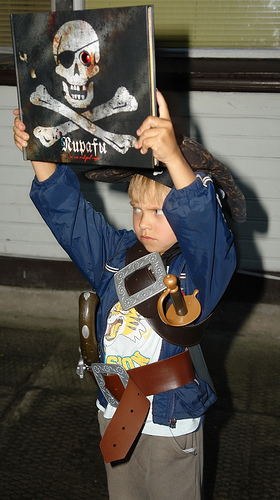

In [64]:
test_image = pred_caption(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

BELU score: 100.0
Real Caption: large bird swooping down towards the ground
Prediction Caption: large bird swooping down towards the ground


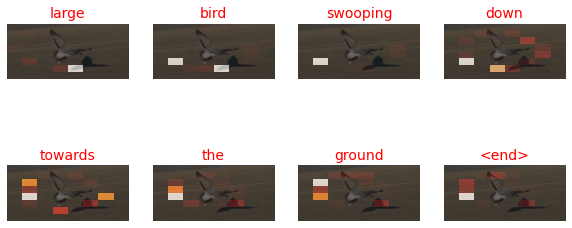

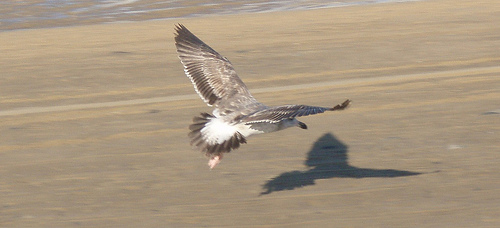

In [101]:
test_image = pred_caption(len(image_test), True, weights = (0.75, 0.25, 0, 0))
Image.open(test_image)

BELU score: 100.0
Real Caption: the people are standing in front of building
Prediction Caption: the people are standing in front of building


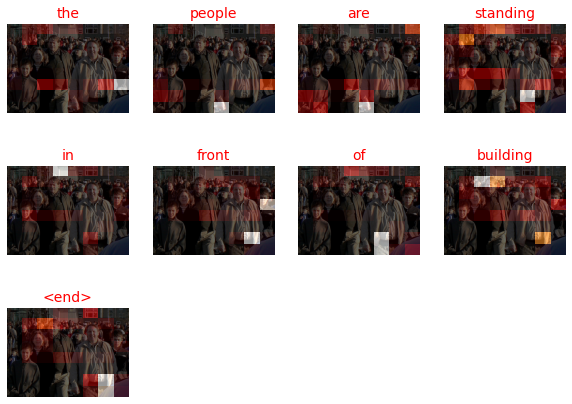

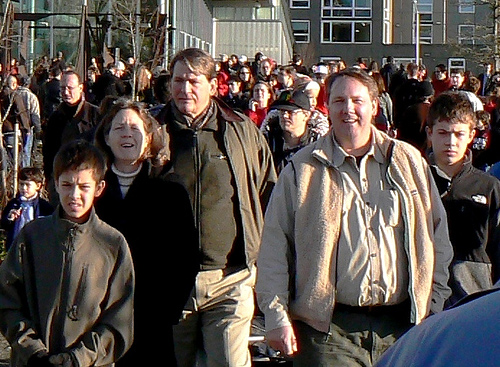

In [113]:
test_image = pred_caption(len(image_test), True, weights = (0.75, 0.25, 0, 0))
Image.open(test_image)

BELU score: 100.0
Real Caption: man with gauges and glasses is wearing UNK hat
Prediction Caption: man with gauges and glasses is wearing UNK hat


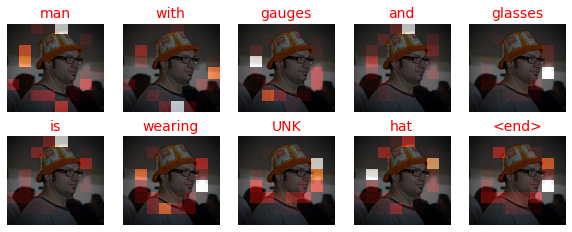

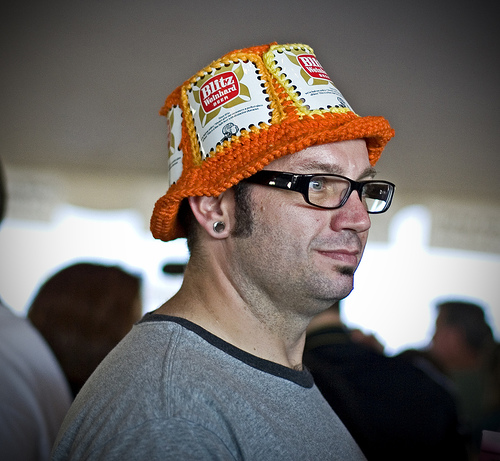

In [123]:
test_image = pred_caption(len(image_test), True, weights = (0.75, 0.25, 0, 0))
Image.open(test_image)

BELU score: 80.0552988489833
Real Caption: three dogs playing in the green water
Prediction Caption: three dogs playing in the water


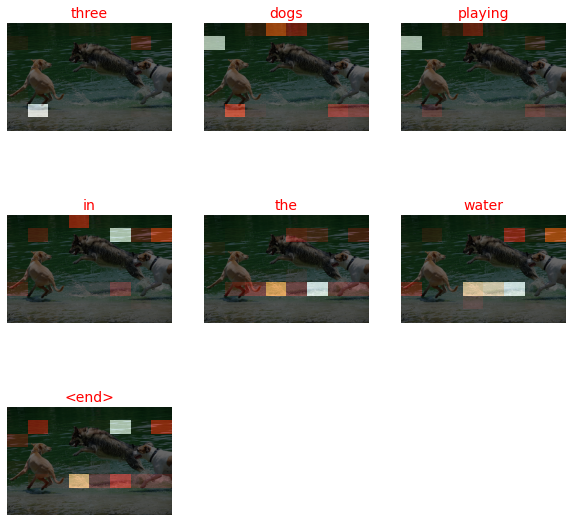

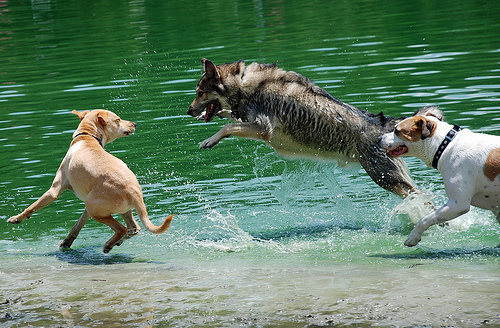

In [124]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)